In [1]:
%load_ext dotenv
%dotenv 

In [2]:
from pymongo import MongoClient
import os
from datasets import Dataset
import re
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import plotly.express as px
from tqdm import tqdm
import pandas as pd

In [3]:
ID = "1308026329"
MODEL_ID = "gpt2"

In [4]:
mongo_conn = MongoClient(os.environ["MONGO_CONN"])
db = mongo_conn.twitter  # our database

subjects_collection = db["subjects_collection"]
timelines_collection = db["timelines_collection"]
peers_collection = db["peers_collection"]

# User

In [5]:
subject = subjects_collection.find_one({"id": ID})
subject

{'_id': ObjectId('63de1efed7f30964c36bb079'),
 'created_at': '2013-03-27T16:58:10.000Z',
 'description': 'Forever reading too many books at once while trying to find the perfect red lip. 👌🏼 bookstagram @starless.reader 📚',
 'entities': {'url': {'urls': [{'start': 0,
     'end': 23,
     'url': 'https://t.co/UCwYGISyGI',
     'expanded_url': 'http://www.shewritesaboutbooks.com',
     'display_url': 'shewritesaboutbooks.com'}]},
  'description': {'mentions': [{'start': 96,
     'end': 105,
     'username': 'starless'}]}},
 'id': '1308026329',
 'location': 'Perth, Australia',
 'name': 'Ｓａｍａｎｔｈａ．💜',
 'profile_image_url': 'https://pbs.twimg.com/profile_images/839815038844063744/rUZwGFvu_normal.jpg',
 'protected': False,
 'public_metrics': {'followers_count': 857,
  'following_count': 826,
  'tweet_count': 8750,
  'listed_count': 14},
 'url': 'https://t.co/UCwYGISyGI',
 'username': 'starless_reader',
 'verified': False,
 'verified_type': 'none',
 'timeline_tweets_count': 648}

# User tweets

In [6]:
user_tweets = list(timelines_collection.find({"author_id": ID, "referenced_tweets.type": {"$ne": "retweeted"}}, {"_id": 0}))

for tweet, _ in zip(user_tweets, range(10)):
    print(tweet["text"])

@PaperFury I’m taking this as a personal attack now. 😂😂 https://t.co/wRzxfTzTpH
@PaperFury I did not ask to be called out like that 😂 https://t.co/lvHYjvAvgL
The absolute best news to wake up to! 🥳🥳🥳🥳 https://t.co/SK3braPmNf
🥳🥳🥳🥳 https://t.co/yAtO3LsHMq
@bookswithneeks As someone who is reading it and enjoying it… You’ll probably hate it 😂😂
A mood https://t.co/3ZEwWopeAY
@PaperFury All day, every day 💁🏻‍♀️💁🏻‍♀️
@PaperFury Still a ten 💁🏻‍♀️
@PaperFury Omg 😂😂😂😂😂
@shleyreads Ummmm gross?!


In [7]:
user_tweets[0]

{'created_at': '2023-01-16T13:25:49.000Z',
 'in_reply_to_user_id': '1381015116',
 'entities': {'mentions': [{'start': 0,
    'end': 10,
    'username': 'PaperFury',
    'id': '1381015116'}],
  'urls': [{'start': 56,
    'end': 79,
    'url': 'https://t.co/wRzxfTzTpH',
    'expanded_url': 'https://twitter.com/PaperFury/status/1614975937589968897',
    'display_url': 'twitter.com/PaperFury/stat…'}]},
 'public_metrics': {'retweet_count': 0,
  'reply_count': 0,
  'like_count': 0,
  'quote_count': 0,
  'impression_count': 19},
 'referenced_tweets': [{'type': 'quoted', 'id': '1614975937589968897'}],
 'possibly_sensitive': False,
 'lang': 'en',
 'author_id': '1308026329',
 'edit_history_tweet_ids': ['1614977223655829505'],
 'edit_controls': {'edits_remaining': 5,
  'is_edit_eligible': True,
  'editable_until': datetime.datetime(2023, 1, 16, 13, 55, 49)},
 'conversation_id': '1614977223655829505',
 'text': '@PaperFury I’m taking this as a personal attack now. 😂😂 https://t.co/wRzxfTzTpH',
 'id'

## Dataset

In [8]:
tweets_dataset = Dataset.from_list(user_tweets)

In [9]:
tweets_dataset

Dataset({
    features: ['created_at', 'in_reply_to_user_id', 'entities', 'public_metrics', 'referenced_tweets', 'possibly_sensitive', 'lang', 'author_id', 'edit_history_tweet_ids', 'edit_controls', 'conversation_id', 'text', 'id', 'reply_settings', 'queried_at'],
    num_rows: 659
})

In [10]:
sample = tweets_dataset.select(range(25))

In [11]:
for tweet in sample:
    print(tweet["text"])

@PaperFury I’m taking this as a personal attack now. 😂😂 https://t.co/wRzxfTzTpH
@PaperFury I did not ask to be called out like that 😂 https://t.co/lvHYjvAvgL
The absolute best news to wake up to! 🥳🥳🥳🥳 https://t.co/SK3braPmNf
🥳🥳🥳🥳 https://t.co/yAtO3LsHMq
@bookswithneeks As someone who is reading it and enjoying it… You’ll probably hate it 😂😂
A mood https://t.co/3ZEwWopeAY
@PaperFury All day, every day 💁🏻‍♀️💁🏻‍♀️
@PaperFury Still a ten 💁🏻‍♀️
@PaperFury Omg 😂😂😂😂😂
@shleyreads Ummmm gross?!
Ahhhhh that’s so exciting 🥳🥳🥳🥳 https://t.co/XOD2dxg8gH
@shleyreads YES YOU CAN
@shleyreads … buy it
@shleyreads @srpntsxscorpios We have never my claimed otherwise 💁🏻‍♀️😂
@shleyreads Buuuuuuuy them Ashley 😂
@bookswithneeks Oh I will keep you updated 😂😂
@bookswithneeks I really wish I could tell you but I am 3 episodes in and can’t figure it out 🤷🏻‍♀️😂
@shleyreads ASHLEY IS THIS THE HOT DAD?
@srpntsxscorpios 😂😂😂😂😂
@srpntsxscorpios Woman go to bed, you’ll find out soon enough 😂😂😂
@shleyreads ASHLEY YOU BAB

### Preprocess text

In [12]:
def remove_urls(x):
    return {"text": re.sub(r"http\S+", "", x["text"])}

def remove_extra_spaces(x):
    return {"text": " ".join(x["text"].split())}

In [13]:
updated_sample = sample.map(remove_urls).map(remove_extra_spaces)

  0%|          | 0/25 [00:00<?, ?ex/s]

  0%|          | 0/25 [00:00<?, ?ex/s]

In [14]:
for tweet in updated_sample:
    print(tweet["text"])

@PaperFury I’m taking this as a personal attack now. 😂😂
@PaperFury I did not ask to be called out like that 😂
The absolute best news to wake up to! 🥳🥳🥳🥳
🥳🥳🥳🥳
@bookswithneeks As someone who is reading it and enjoying it… You’ll probably hate it 😂😂
A mood
@PaperFury All day, every day 💁🏻‍♀️💁🏻‍♀️
@PaperFury Still a ten 💁🏻‍♀️
@PaperFury Omg 😂😂😂😂😂
@shleyreads Ummmm gross?!
Ahhhhh that’s so exciting 🥳🥳🥳🥳
@shleyreads YES YOU CAN
@shleyreads … buy it
@shleyreads @srpntsxscorpios We have never my claimed otherwise 💁🏻‍♀️😂
@shleyreads Buuuuuuuy them Ashley 😂
@bookswithneeks Oh I will keep you updated 😂😂
@bookswithneeks I really wish I could tell you but I am 3 episodes in and can’t figure it out 🤷🏻‍♀️😂
@shleyreads ASHLEY IS THIS THE HOT DAD?
@srpntsxscorpios 😂😂😂😂😂
@srpntsxscorpios Woman go to bed, you’ll find out soon enough 😂😂😂
@shleyreads ASHLEY YOU BABE 😍😍😍
Or, and just a thought, we could not steal books and potentially ruin authors careers. 🤷🏻‍♀️
@thatidiotfrank Rude 😂😂😂😂
@hannahplusone You’

### Tokenization

In [15]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

In [16]:
text = updated_sample[0]["text"]
text_tokenized = tokenizer.tokenize(text)
ids = tokenizer.convert_tokens_to_ids(text_tokenized)
print(text)
print(text_tokenized)
print(ids)

@PaperFury I’m taking this as a personal attack now. 😂😂
['@', 'Paper', 'F', 'ury', 'ĠI', 'âĢ', 'Ļ', 'm', 'Ġtaking', 'Ġthis', 'Ġas', 'Ġa', 'Ġpersonal', 'Ġattack', 'Ġnow', '.', 'ĠðŁĺ', 'Ĥ', 'ðŁĺ', 'Ĥ']
[31, 42950, 37, 1601, 314, 447, 247, 76, 2263, 428, 355, 257, 2614, 1368, 783, 13, 30325, 224, 47249, 224]


In [17]:
decoded = tokenizer.decode(ids)
print(decoded)

@PaperFury I’m taking this as a personal attack now. 😂😂


In [18]:
tokenizer.truncation_side = "left"
tokenizer.truncation_side

'left'

### Model

In [22]:
model = AutoModelForCausalLM.from_pretrained(MODEL_ID)

#### Perplexity

In [60]:
inp = tokenizer(text, return_tensors="pt")
inp

{'input_ids': tensor([[   31, 42950,    37,  1601,   314,   447,   247,    76,  2263,   428,
           355,   257,  2614,  1368,   783,    13, 30325,   224, 47249,   224]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [61]:
input_ids = inp.input_ids

target_ids = input_ids.clone()

In [62]:
input_ids.shape

torch.Size([1, 20])

In [63]:
with torch.no_grad():
    outputs = model(input_ids, labels=target_ids) # the model internally shifts the target ids to the left for next-word prediction
    neg_log_likelihood = outputs.loss # the loss is a cross-entropy loss

In [64]:
outputs.logits

tensor([[[-34.1510, -32.9267, -34.6145,  ..., -41.9141, -42.4946, -33.3369],
         [-64.7886, -62.2584, -65.0270,  ..., -73.8592, -73.8884, -64.6169],
         [-67.0678, -65.1252, -62.4221,  ..., -77.4963, -75.9399, -65.8218],
         ...,
         [-87.7823, -85.1541, -82.5312,  ..., -98.6305, -97.4418, -83.2104],
         [-48.7254, -50.0082, -46.7284,  ..., -58.2389, -57.6016, -49.1910],
         [-74.0530, -72.1501, -71.1299,  ..., -85.7036, -84.5447, -71.3885]]])

In [65]:
outputs.logits.shape

torch.Size([1, 20, 50257])

Size: [batch_size, num_predicted_tokens, vocab_size]

In [67]:
outputs.loss

tensor(5.1768)

In [86]:
from torch.nn import CrossEntropyLoss
loss_fct = CrossEntropyLoss(reduction="none")

In [82]:
shifted_labels = target_ids[..., 1:].contiguous()
shifted_logits = outputs.logits[..., :-1, :].contiguous()

print(shifted_labels)
print(shifted_logits)

tensor([[42950,    37,  1601,   314,   447,   247,    76,  2263,   428,   355,
           257,  2614,  1368,   783,    13, 30325,   224, 47249,   224]])
tensor([[[-34.1510, -32.9267, -34.6145,  ..., -41.9141, -42.4946, -33.3369],
         [-64.7886, -62.2584, -65.0270,  ..., -73.8592, -73.8884, -64.6169],
         [-67.0678, -65.1252, -62.4221,  ..., -77.4963, -75.9399, -65.8218],
         ...,
         [-58.4186, -58.1354, -55.1670,  ..., -66.4870, -67.2714, -56.9353],
         [-87.7823, -85.1541, -82.5312,  ..., -98.6305, -97.4418, -83.2104],
         [-48.7254, -50.0082, -46.7284,  ..., -58.2389, -57.6016, -49.1910]]])


In [83]:
shifted_logits.shape

torch.Size([1, 19, 50257])

In [87]:
loss = loss_fct(shifted_logits.view(-1, shifted_logits.size(-1)), shifted_labels.view(-1))

print(loss)
print(loss.mean())

tensor([11.4267,  6.8624,  5.7911,  7.7863, 12.7187,  8.5493,  4.4899,  6.4299,
         2.8883,  3.9914,  0.7380,  3.3331,  3.8581,  7.1239,  1.1248,  7.7123,
         2.2923,  1.0810,  0.1616])
tensor(5.1768)


In [26]:
ppl = torch.exp(neg_log_likelihood).item()
print("Text: ", text)
print("Perplexity: ", ppl)

Text:  @PaperFury I’m taking this as a personal attack now. 😂😂
Perplexity:  177.11534118652344


#### Perplexity with context

Where context is < 1024 tokens

In [27]:
tokens_in_text = input_ids.shape[1] # how many tokens to calculate ppl on

full_text = " ".join(reversed(updated_sample[:]["text"]))

print("Full text: ", full_text)

Full text:  @PaperFury I have never said otherwise 💁🏻‍♀️😂 @hannahplusone You’d think that would be common sense 😂 @thatidiotfrank Rude 😂😂😂😂 Or, and just a thought, we could not steal books and potentially ruin authors careers. 🤷🏻‍♀️ @shleyreads ASHLEY YOU BABE 😍😍😍 @srpntsxscorpios Woman go to bed, you’ll find out soon enough 😂😂😂 @srpntsxscorpios 😂😂😂😂😂 @shleyreads ASHLEY IS THIS THE HOT DAD? @bookswithneeks I really wish I could tell you but I am 3 episodes in and can’t figure it out 🤷🏻‍♀️😂 @bookswithneeks Oh I will keep you updated 😂😂 @shleyreads Buuuuuuuy them Ashley 😂 @shleyreads @srpntsxscorpios We have never my claimed otherwise 💁🏻‍♀️😂 @shleyreads … buy it @shleyreads YES YOU CAN Ahhhhh that’s so exciting 🥳🥳🥳🥳 @shleyreads Ummmm gross?! @PaperFury Omg 😂😂😂😂😂 @PaperFury Still a ten 💁🏻‍♀️ @PaperFury All day, every day 💁🏻‍♀️💁🏻‍♀️ A mood @bookswithneeks As someone who is reading it and enjoying it… You’ll probably hate it 😂😂 🥳🥳🥳🥳 The absolute best news to wake up to! 🥳🥳🥳🥳 @PaperFury I di

In [28]:
inp = tokenizer(full_text, return_tensors="pt")

print(inp)

{'input_ids': tensor([[   31, 42950,    37,  1601,   314,   423,  1239,   531,  4306, 12520,
           240,   223,  8582,   237,   119,   447,   235, 17992,   222, 37929,
         47249,   224,  2488,    71, 25761,  9541,   505,   921,   447,   247,
            67,   892,   326,   561,   307,  2219,  2565, 30325,   224,  2488,
          5562,   312,  5151,  8310,   962,   371,  2507, 30325,   224, 47249,
           224, 47249,   224, 47249,   224,  1471,    11,   290,   655,   257,
          1807,    11,   356,   714,   407,  8711,  3835,   290,  6196, 16866,
          7035, 16179,    13, 12520,    97,   115,  8582,   237,   119,   447,
           235, 17992,   222, 37929,  2488,  1477,  1636, 40779,  7054,    39,
         25173,  7013,   347,  6242,    36, 30325,   235, 47249,   235, 47249,
           235,  2488, 27891,    79,   429,    82,    87,  1416, 16300,  4267,
         14381,   467,   284,  3996,    11,   345,   447,   247,   297,  1064,
           503,  2582,  1576, 30325,  

In [29]:
tokenizer.decode(inp.input_ids[:, :-tokens_in_text].flatten())

'@PaperFury I have never said otherwise 💁🏻\u200d♀️😂 @hannahplusone You’d think that would be common sense 😂 @thatidiotfrank Rude 😂😂😂😂 Or, and just a thought, we could not steal books and potentially ruin authors careers. 🤷🏻\u200d♀️ @shleyreads ASHLEY YOU BABE 😍😍😍 @srpntsxscorpios Woman go to bed, you’ll find out soon enough 😂😂😂 @srpntsxscorpios 😂😂😂😂😂 @shleyreads ASHLEY IS THIS THE HOT DAD? @bookswithneeks I really wish I could tell you but I am 3 episodes in and can’t figure it out 🤷🏻\u200d♀️😂 @bookswithneeks Oh I will keep you updated 😂😂 @shleyreads Buuuuuuuy them Ashley 😂 @shleyreads @srpntsxscorpios We have never my claimed otherwise 💁🏻\u200d♀️😂 @shleyreads … buy it @shleyreads YES YOU CAN Ahhhhh that’s so exciting 🥳🥳🥳🥳 @shleyreads Ummmm gross?! @PaperFury Omg 😂😂😂😂😂 @PaperFury Still a ten 💁🏻\u200d♀️ @PaperFury All day, every day 💁🏻\u200d♀️💁🏻\u200d♀️ A mood @bookswithneeks As someone who is reading it and enjoying it… You’ll probably hate it 😂😂 🥳🥳🥳🥳 The absolute best news to wake up 

In [30]:
input_ids = inp.input_ids
target_ids = input_ids.clone()
target_ids[:, :-tokens_in_text] = -100 # ignore the context when calculating the perplexity

In [31]:
with torch.no_grad():
    outputs = model(input_ids, labels=target_ids) # the model internally shifts the target ids to the left for next-word prediction
    neg_log_likelihood = outputs.loss # the loss is a cross-entropy loss
    
ppl = torch.exp(neg_log_likelihood).item()
context_tweets = updated_sample[1:]["text"]
print("Context (%d tweets):\n%s\n" % (len(context_tweets), " ".join(context_tweets)))
print("Text: ", text)
print("Perplexity: ", ppl)

Context (24 tweets):
@PaperFury I did not ask to be called out like that 😂 The absolute best news to wake up to! 🥳🥳🥳🥳 🥳🥳🥳🥳 @bookswithneeks As someone who is reading it and enjoying it… You’ll probably hate it 😂😂 A mood @PaperFury All day, every day 💁🏻‍♀️💁🏻‍♀️ @PaperFury Still a ten 💁🏻‍♀️ @PaperFury Omg 😂😂😂😂😂 @shleyreads Ummmm gross?! Ahhhhh that’s so exciting 🥳🥳🥳🥳 @shleyreads YES YOU CAN @shleyreads … buy it @shleyreads @srpntsxscorpios We have never my claimed otherwise 💁🏻‍♀️😂 @shleyreads Buuuuuuuy them Ashley 😂 @bookswithneeks Oh I will keep you updated 😂😂 @bookswithneeks I really wish I could tell you but I am 3 episodes in and can’t figure it out 🤷🏻‍♀️😂 @shleyreads ASHLEY IS THIS THE HOT DAD? @srpntsxscorpios 😂😂😂😂😂 @srpntsxscorpios Woman go to bed, you’ll find out soon enough 😂😂😂 @shleyreads ASHLEY YOU BABE 😍😍😍 Or, and just a thought, we could not steal books and potentially ruin authors careers. 🤷🏻‍♀️ @thatidiotfrank Rude 😂😂😂😂 @hannahplusone You’d think that would be common sense 

We have managed to bring down the perplexity of 177 down to 12!

#### Perplexity with increasing context

In [32]:
def ppl_calculator(text, context):
    text_tokens = tokenizer.tokenize(text)
    tokens_in_text = len(text_tokens) # how many tokens to calculate ppl on
    
    if context != "":
        full_text = " ".join([context, text])
    else:
        full_text = text
        
    assert tokenizer.truncation_side == "left"
    
    inp = tokenizer(full_text, return_tensors="pt", truncation=True) # truncation ensures the length is 1024 at most!
    input_ids = inp.input_ids
    target_ids = input_ids.clone()
    target_ids[:, :-tokens_in_text] = -100 # ignore the context when calculating the perplexity
    
    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids) # the model internally shifts the target ids to the left for next-word prediction
        neg_log_likelihood = outputs.loss # the loss is a cross-entropy loss
    
    ppl = torch.exp(neg_log_likelihood).item()
    return ppl

In [33]:
print(text)

@PaperFury I’m taking this as a personal attack now. 😂😂


In [34]:
ppl_calculator(text, context="")

177.11534118652344

In [35]:
context = " ".join(reversed(updated_sample[1:]["text"]))
print(context)

@PaperFury I have never said otherwise 💁🏻‍♀️😂 @hannahplusone You’d think that would be common sense 😂 @thatidiotfrank Rude 😂😂😂😂 Or, and just a thought, we could not steal books and potentially ruin authors careers. 🤷🏻‍♀️ @shleyreads ASHLEY YOU BABE 😍😍😍 @srpntsxscorpios Woman go to bed, you’ll find out soon enough 😂😂😂 @srpntsxscorpios 😂😂😂😂😂 @shleyreads ASHLEY IS THIS THE HOT DAD? @bookswithneeks I really wish I could tell you but I am 3 episodes in and can’t figure it out 🤷🏻‍♀️😂 @bookswithneeks Oh I will keep you updated 😂😂 @shleyreads Buuuuuuuy them Ashley 😂 @shleyreads @srpntsxscorpios We have never my claimed otherwise 💁🏻‍♀️😂 @shleyreads … buy it @shleyreads YES YOU CAN Ahhhhh that’s so exciting 🥳🥳🥳🥳 @shleyreads Ummmm gross?! @PaperFury Omg 😂😂😂😂😂 @PaperFury Still a ten 💁🏻‍♀️ @PaperFury All day, every day 💁🏻‍♀️💁🏻‍♀️ A mood @bookswithneeks As someone who is reading it and enjoying it… You’ll probably hate it 😂😂 🥳🥳🥳🥳 The absolute best news to wake up to! 🥳🥳🥳🥳 @PaperFury I did not ask to

In [36]:
ppl_calculator(text, context=context)

11.968624114990234

Let's see how fast the perplexity decreases as we add on more and more tweets!

In [37]:
ppl_list = []

for n_tweets in range(25):
    context = " ".join(reversed(updated_sample[1:1+n_tweets]["text"]))
    
    ppl_list.append(ppl_calculator(text, context))

print(ppl_list)

[177.11534118652344, 32.52310562133789, 32.2797966003418, 33.430545806884766, 14.65011978149414, 16.053264617919922, 17.15653419494629, 17.18528938293457, 16.103225708007812, 15.72437858581543, 14.890024185180664, 14.99577808380127, 14.805232048034668, 14.475643157958984, 13.40746784210205, 14.060617446899414, 12.99242877960205, 12.673209190368652, 12.484917640686035, 12.708534240722656, 12.753255844116211, 12.975131034851074, 12.757884979248047, 11.622344970703125, 11.968624114990234]


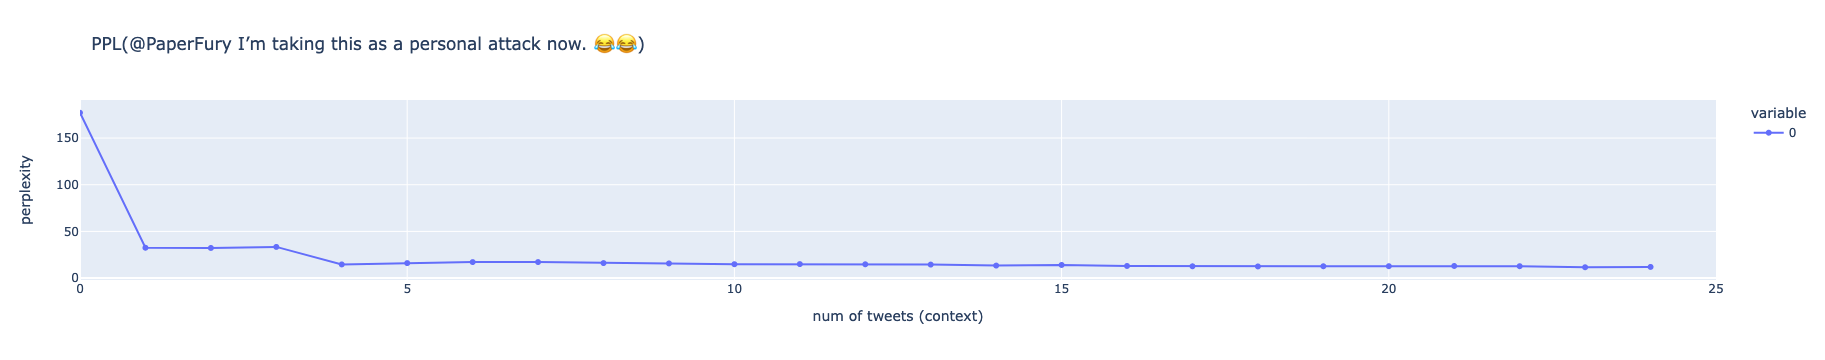

In [53]:
fig = px.line(ppl_list, markers=True, title=f"PPL({text})")

fig.update_yaxes(title="perplexity")
fig.update_xaxes(title="num of tweets (context)", range=(0,25))

~~Btw getting perplexity down to ~12 is very good, especially since Bagrow et al. (2019)'s average user had an entropy of $h=6$, which means that the perplexity was $2^h=64$. An interpreteation of this is that the model is as confused as having to predict uniformly randomly among 64 words. Our model on the other hand is only as confused as having to choose uniformly randomly among 12 words!~~

~~In conclusion, the non-finetuned, context-fed gpt-2 model is able to beat Bagrow et al.'s "best algorithm" estimate!~~

You can't compare the two results - Bagrow et al. uses word-level entropy, we use token-level. They measure information in bits, here it's in nats. They have a vocabulary of 5000, we have 50000. The list goes on.

# Peer tweets

## Peers

In [39]:
subject["id"]

'1308026329'

In [40]:
peers_list = list(peers_collection.find({"mentioned_by.id": subject["id"]}, {"_id": 0}))

for peer in peers_list:
    mention = next( filter(lambda x: x["id"] == subject["id"] , peer["mentioned_by"]), None )
    print(f"username: {peer['username']} / mentioned {mention['num_mentions']} times / num tweets: {peer['timeline_tweets_count']}")

username: thatidiotfrank / mentioned 79 times / num tweets: 99
username: tea_readss / mentioned 51 times / num tweets: 96
username: PaperFury / mentioned 40 times / num tweets: 94
username: thecosyreader / mentioned 14 times / num tweets: 90
username: SundayLuxe / mentioned 9 times / num tweets: 28
username: shleyreads / mentioned 7 times / num tweets: 98
username: sofiaecasanova / mentioned 7 times / num tweets: 85
username: Explore_a_thon / mentioned 6 times / num tweets: 100
username: bookswithneeks / mentioned 5 times / num tweets: 97
username: ashmcl_ / mentioned 5 times / num tweets: 94
username: udeadah / mentioned 4 times / num tweets: 83
username: DateaBook / mentioned 4 times / num tweets: 100


There are 12 peers, so if we get 3 tweets each we should have more than enough to reproduce the above results...

In [41]:
peer_tweets = []
for peer in peers_list:
    user_tweets = list(timelines_collection.find({"author_id": peer['id'], "referenced_tweets.type": {"$ne": "retweeted"}}, {"_id": 0}).limit(3))
    peer_tweets.extend(user_tweets)

### Peers dataset

In [42]:
peers_dataset = Dataset.from_list(peer_tweets).shuffle(56)

for tweet in peers_dataset.select(range(3)):
    print(f"@{tweet['author_id']}: {tweet['text']}")

@389514735: i’m so glad i started making reaction videos on youtube and i love making those videos but the comments i get on that channel are something else compared to booktube omfg
@1060512485319438336: I’ve been to the climbing gym like 4 times maybe now and each time between me coming is at least a month so any progress I make is lost and basically all of this is to say I suck at climbing like so damn bad it’s kinda embarrassing
@1073702576418304000: Full offence if you’re on school holidays right now I hate you
I’m over work telling me to take my excess leave but then turning around and saying JK THERE ISN’T ANY AVAILABLE


#### Preprocess

In [43]:
peers_dataset = peers_dataset.map(remove_urls).map(remove_extra_spaces)

  0%|          | 0/36 [00:00<?, ?ex/s]

  0%|          | 0/36 [00:00<?, ?ex/s]

### Perplexity on a mixed set of peer tweets

In [44]:
text

'@PaperFury I’m taking this as a personal attack now. 😂😂'

In [45]:
peer_ppl_list = []

for n_tweets in range(25):
    context = " ".join(reversed(peers_dataset[:n_tweets]["text"]))
    
    peer_ppl_list.append(ppl_calculator(text, context))

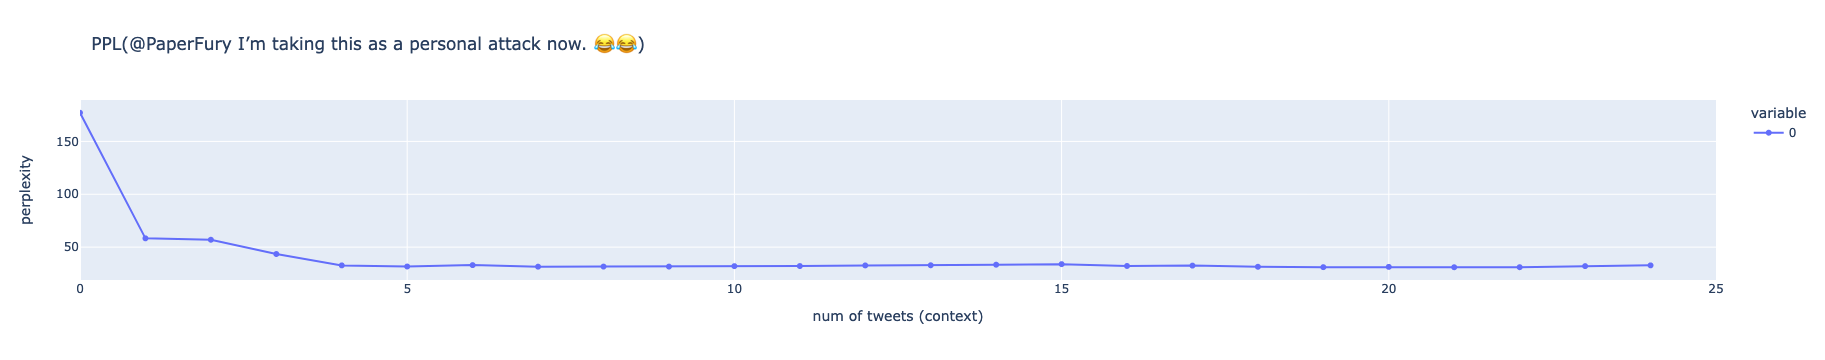

In [54]:
fig = px.line(peer_ppl_list, markers=True, title=f"PPL({text})")

fig.update_yaxes(title="perplexity")
fig.update_xaxes(title="num of tweets (context)", range=(0,25))

With the peer's tweets as context, we could only go down to 32. 

However,
- convergence was similar (around 5)
- adding more tweets doesn't seem to improve results

### Perplexity on individual peer tweets

In [50]:
ppl_per_peer = []

for peer in tqdm(peers_list):
    mention = next( filter(lambda x: x["id"] == subject["id"] , peer["mentioned_by"]), None )
    
    peer_tweets = list(timelines_collection.find({"author_id": peer['id'], "referenced_tweets.type": {"$ne": "retweeted"}}, {"_id": 0}).limit(25))
    peer_tweets = Dataset.from_list(peer_tweets).map(remove_urls).map(remove_extra_spaces)
    
    for n_tweets in range(25):
        context = " ".join(reversed(peer_tweets[:n_tweets]["text"]))
        ppl = ppl_calculator(text, context)
        
        data = {}
        data['id'] = peer['id']
        data['username'] = peer['username']
        data['rank'] = mention['rank']
        data['mentions'] = mention['num_mentions']
        data['n_tweets'] = n_tweets
        data['perplexity'] = ppl
        
        ppl_per_peer.append(data)

  0%|                                                                                                                                | 0/12 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?ex/s]

  0%|          | 0/25 [00:00<?, ?ex/s]

  8%|██████████                                                                                                              | 1/12 [00:18<03:20, 18.19s/it]

  0%|          | 0/25 [00:00<?, ?ex/s]

  0%|          | 0/25 [00:00<?, ?ex/s]

 17%|████████████████████                                                                                                    | 2/12 [00:32<02:41, 16.17s/it]

  0%|          | 0/25 [00:00<?, ?ex/s]

  0%|          | 0/25 [00:00<?, ?ex/s]

 25%|██████████████████████████████                                                                                          | 3/12 [00:50<02:29, 16.60s/it]

  0%|          | 0/25 [00:00<?, ?ex/s]

  0%|          | 0/25 [00:00<?, ?ex/s]

 33%|████████████████████████████████████████                                                                                | 4/12 [01:03<02:01, 15.20s/it]

  0%|          | 0/25 [00:00<?, ?ex/s]

  0%|          | 0/25 [00:00<?, ?ex/s]

 42%|██████████████████████████████████████████████████                                                                      | 5/12 [01:18<01:47, 15.29s/it]

  0%|          | 0/25 [00:00<?, ?ex/s]

  0%|          | 0/25 [00:00<?, ?ex/s]

 50%|████████████████████████████████████████████████████████████                                                            | 6/12 [01:30<01:24, 14.11s/it]

  0%|          | 0/25 [00:00<?, ?ex/s]

  0%|          | 0/25 [00:00<?, ?ex/s]

 58%|██████████████████████████████████████████████████████████████████████                                                  | 7/12 [01:39<01:01, 12.40s/it]

  0%|          | 0/25 [00:00<?, ?ex/s]

  0%|          | 0/25 [00:00<?, ?ex/s]

 67%|████████████████████████████████████████████████████████████████████████████████                                        | 8/12 [02:04<01:05, 16.44s/it]

  0%|          | 0/25 [00:00<?, ?ex/s]

  0%|          | 0/25 [00:00<?, ?ex/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 9/12 [02:22<00:51, 17.00s/it]

  0%|          | 0/25 [00:00<?, ?ex/s]

  0%|          | 0/25 [00:00<?, ?ex/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 10/12 [02:34<00:30, 15.41s/it]

  0%|          | 0/25 [00:00<?, ?ex/s]

  0%|          | 0/25 [00:00<?, ?ex/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 11/12 [02:45<00:13, 13.94s/it]

  0%|          | 0/25 [00:00<?, ?ex/s]

  0%|          | 0/25 [00:00<?, ?ex/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [03:14<00:00, 16.24s/it]


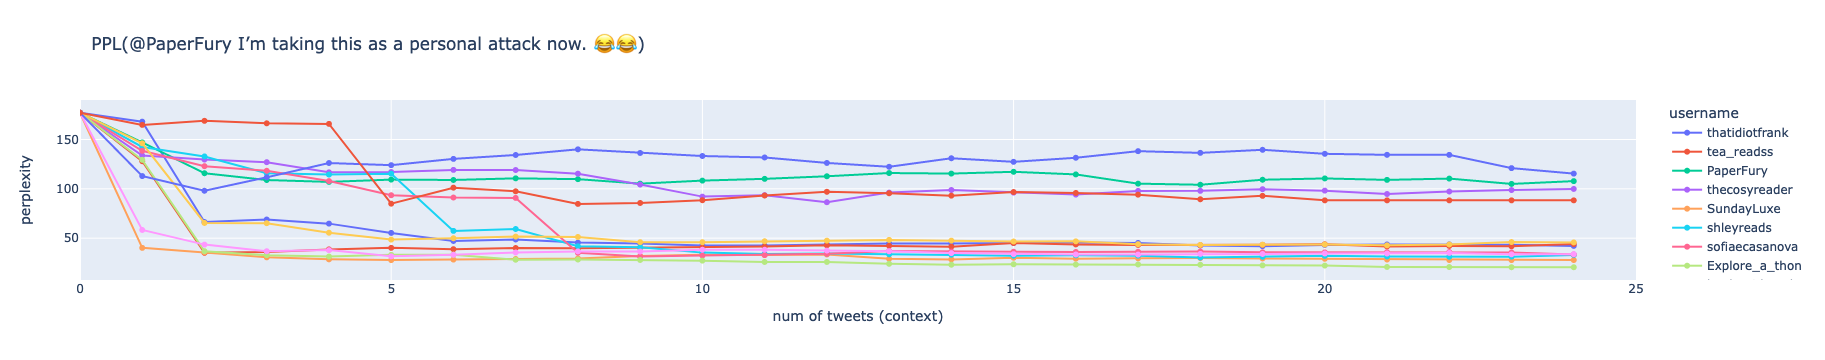

In [55]:
fig = px.line(ppl_per_peer, y="perplexity", x="n_tweets", markers=True, color="username", hover_name="username", hover_data=["rank", "mentions"], title=f"PPL({text})")

fig.update_yaxes(title="perplexity")
fig.update_xaxes(title="num of tweets (context)", range=(0,25))

There is no clear relationship between frequently mentioning someone and their tweets lowering the perplexity...

But, the convergence around 5 tweets does hold quite well!

# Tweets from random users

In [91]:
rand_user_list = list(peers_collection.aggregate([ { "$sample": { "size": 15 } } ]))

for peer in rand_user_list:
    print(f"username: {peer['username']}")

rand_user_tweets = []
for peer in rand_user_list:
    user_tweets = list(timelines_collection.find({"author_id": peer['id'], "referenced_tweets.type": {"$ne": "retweeted"}}, {"_id": 0}).limit(3))
    rand_user_tweets.extend(user_tweets)

### Peers dataset

rand_user_dataset = Dataset.from_list(rand_user_tweets).shuffle(56)

for tweet in rand_user_dataset.select(range(3)):
    print(f"@{tweet['author_id']}: {tweet['text']}")

#### Preprocess

rand_user_dataset = rand_user_dataset.map(remove_urls).map(remove_extra_spaces)

username: hyukaireen
username: prettyredlips21
username: DevilishEnd
username: STLChildrens
username: JawnO
username: dieboldcomics
username: LagoonTrading
username: mfarrellsports
username: simonsinek
username: persiika
username: MiaOBrienTV
username: pjmtrendingsong
username: nbilka
username: mindykaling
username: LLinWood
@187680645: Discernment. https://t.co/4chSstOVkR
@170021040: 3-Point Stance: these dudes are gonna be under pressure 

https://t.co/DvbeHvGPki
@15970050: Directions are instructions given to explain HOW.
Direction is a vision offered to explain WHY.


  0%|          | 0/45 [00:00<?, ?ex/s]

  0%|          | 0/45 [00:00<?, ?ex/s]

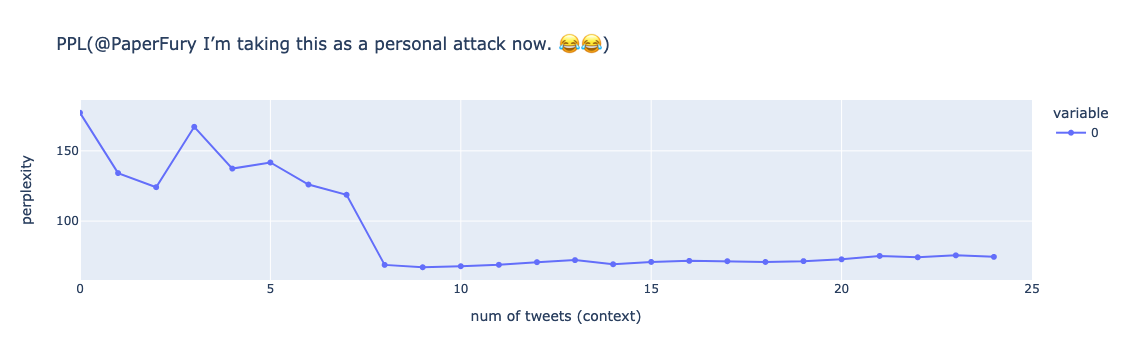

In [92]:
rand_user_ppl_list = []

for n_tweets in range(25):
    context = " ".join(reversed(rand_user_dataset[:n_tweets]["text"]))
    
    rand_user_ppl_list.append(ppl_calculator(text, context))

fig = px.line(rand_user_ppl_list, markers=True, title=f"PPL({text})")

fig.update_yaxes(title="perplexity")
fig.update_xaxes(title="num of tweets (context)", range=(0,25))

With tweets from random users, the perplexity seems pretty unstable and converges only to around 70!